### 2023-07-07 radiation port validation

Demonstrate that the radiation port validates against Fortran radiation scheme for nudged run clouds.

In [1]:
import dataclasses
import os
from string import ascii_lowercase
import cftime
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import xarray as xr
import fv3viz
from vcm.fv3.metadata import standardize_fv3_diagnostics
from vcm.catalog import catalog as CATALOG

In [2]:
@dataclasses.dataclass
class RadiationDiagnostic:
    fortran_name: str
    standard_name: str
    python_suffix: str="python"
        
    @property
    def python_name_from_standard(self):
        return "_".join([self.standard_name, self.python_suffix])

        
RADIATION_DIAGNOSTICS = [
    RadiationDiagnostic('DSWRFtoa', 'total_sky_downward_shortwave_flux_at_top_of_atmosphere'),
#     RadiationDiagnostic('DSWRFItoa', 'instantaneous_total_sky_downward_shortwave_flux_at_top_of_atmosphere'),
    RadiationDiagnostic('DCSWRFsfc', 'clear_sky_downward_shortwave_flux_at_surface'),
    RadiationDiagnostic('UCSWRFsfc', 'clear_sky_upward_shortwave_flux_at_surface'),
    RadiationDiagnostic('UCSWRFtoa', 'clear_sky_upward_shortwave_flux_at_top_of_atmosphere'),
    RadiationDiagnostic('DCLWRFsfc', 'clear_sky_downward_longwave_flux_at_surface'),
    RadiationDiagnostic('UCLWRFsfc', 'clear_sky_upward_longwave_flux_at_surface'),
    RadiationDiagnostic('UCLWRFtoa', 'clear_sky_upward_longwave_flux_at_top_of_atmosphere'),
    RadiationDiagnostic('DSWRFsfc_from_RRTMG', 'total_sky_downward_shortwave_flux_at_surface'),
    RadiationDiagnostic('DSWRFIsfc_from_RRTMG', 'instantaneous_total_sky_downward_shortwave_flux_at_surface'),
    RadiationDiagnostic('USWRFsfc_from_RRTMG', 'total_sky_upward_shortwave_flux_at_surface'),
    RadiationDiagnostic('USWRFIsfc_from_RRTMG', 'instantaneous_total_sky_upward_shortwave_flux_at_surface'),
    RadiationDiagnostic('USWRFtoa', 'total_sky_upward_shortwave_flux_at_top_of_atmosphere'),
#     RadiationDiagnostic('USWRFItoa', 'instantaneous_total_sky_upward_shortwave_flux_at_top_of_atmosphere'),
    RadiationDiagnostic('DLWRFsfc_from_RRTMG', 'total_sky_downward_longwave_flux_at_surface'),
    RadiationDiagnostic('DLWRFIsfc_from_RRTMG', 'instantaneous_total_sky_downward_longwave_flux_at_surface'),
    RadiationDiagnostic('ULWRFsfc_from_RRTMG', 'total_sky_upward_longwave_flux_at_surface'),
#     RadiationDiagnostic('ULWRFsfc', 'prescribed_total_sky_upward_longwave_flux_at_surface'),
    RadiationDiagnostic('ULWRFIsfc', 'instantaneous_total_sky_upward_longwave_flux_at_surface'),
    RadiationDiagnostic('ULWRFtoa', 'total_sky_upward_longwave_flux_at_top_of_atmosphere'),
#     RadiationDiagnostic('ULWRFItoa', 'instantaneous_total_sky_upward_longwave_flux_at_top_of_atmosphere'),
]
NUDGED_RUN_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run'
GRID = CATALOG['grid/c48'].read()
TIME_SNAPSHOT = cftime.DatetimeJulian(2020, 8, 7, 10, 30, 0, 0)
TIME_SLICE = slice(
    cftime.DatetimeJulian(2020, 8, 7, 0, 30, 0, 0),
    cftime.DatetimeJulian(2020, 8, 9, 23, 30, 0, 0),
    4
) # hourly over days 8-10 validation
plt.rcParams['font.size'] = 8
OUTDIR = 'figures_supplemental'

In [3]:
def get_python_fluxes(rundir, zarrname='radiative_fluxes.zarr', radiation_diagnostics=RADIATION_DIAGNOSTICS):
    full_path = os.path.join(rundir, zarrname)
    print(full_path)
    ds = xr.open_zarr(full_path)
    python_fluxes = xr.Dataset()
    for diagnostic in radiation_diagnostics:
        if diagnostic.python_name_from_standard in ds.data_vars:
            python_fluxes[diagnostic.standard_name] = ds[diagnostic.python_name_from_standard]
    return python_fluxes

def get_fortran_fluxes(rundir, zarrname='sfc_dt_atmos.zarr', radiation_diagnostics=RADIATION_DIAGNOSTICS):
    full_path = os.path.join(rundir, zarrname)
    print(full_path)
    ds = standardize_fv3_diagnostics(xr.open_zarr(full_path))
    fortran_fluxes = xr.Dataset()
    for diagnostic in radiation_diagnostics:
        if diagnostic.fortran_name in ds.data_vars:
            fortran_fluxes[diagnostic.standard_name] = ds[diagnostic.fortran_name]
    return fortran_fluxes

In [4]:
python_fluxes = get_python_fluxes(NUDGED_RUN_PATH)
fortran_fluxes = get_fortran_fluxes(NUDGED_RUN_PATH)

gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run/sfc_dt_atmos.zarr


In [5]:
with ProgressBar(): 
    difference_snapshot = (fortran_fluxes - python_fluxes).sel(time=TIME_SNAPSHOT).load()

[########################################] | 100% Completed | 2.53 sms


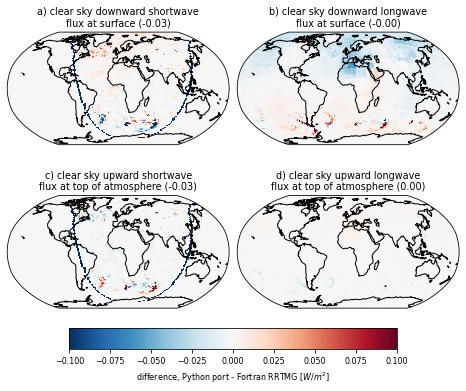

In [14]:
CLEAR_SKY_PLOT_VARS = [
    'clear_sky_downward_shortwave_flux_at_surface',
    'clear_sky_downward_longwave_flux_at_surface',
    'clear_sky_upward_shortwave_flux_at_top_of_atmosphere',
    'clear_sky_upward_longwave_flux_at_top_of_atmosphere'
]

da = difference_snapshot[CLEAR_SKY_PLOT_VARS].to_array(dim='variable_names', name='clear_sky_errors')
da = da.assign_coords({'variable_names': [name.item().replace('_', ' ').replace(' flux', '\nflux') for name in da.variable_names]})
means = da.weighted(GRID.area).mean(dim=['x', 'y', 'tile'])
fig, axes, h, _, fg = fv3viz.plot_cube(
    xr.merge(
        [
            da,
            GRID
        ]
    ),
    'clear_sky_errors',
    col='variable_names',
    col_wrap=2,
    vmin=-0.1,
    vmax=0.1,
    colorbar=False,
    rasterized=True
)
[ax.set_title(f"{letter}) {mean.variable_names.item()} ({mean.item():0.2f})") for ax, mean, letter, in zip(axes.flatten(), means, ascii_lowercase)]
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.15, 0.15, 0.70, 0.05])
fig.colorbar(h[0], cax=cbar_ax, orientation='horizontal', label='difference, Python port - Fortran RRTMG [$W/{m^2}$]')
fig.set_size_inches([6.5, 6])
# fig.set_dpi(100)
# fig.savefig(f'{OUTDIR}/clear_sky_validation_instantaneous.png', bbox_inches='tight')
fig.savefig(f'{OUTDIR}/clear_sky_validation_instantaneous.pdf', bbox_inches='tight')

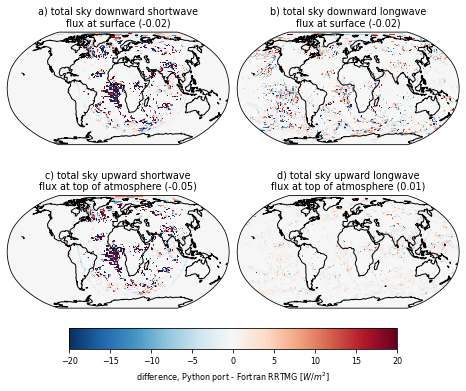

In [12]:
TOTAL_SKY_PLOT_VARS = [
    'total_sky_downward_shortwave_flux_at_surface',
    'total_sky_downward_longwave_flux_at_surface',
    'total_sky_upward_shortwave_flux_at_top_of_atmosphere',
    'total_sky_upward_longwave_flux_at_top_of_atmosphere'
]

da = difference_snapshot[TOTAL_SKY_PLOT_VARS].to_array(dim='variable_names', name='total_sky_errors')
da = da.assign_coords({'variable_names': [name.item().replace('_', ' ').replace(' flux', '\nflux') for name in da.variable_names]})
means = da.weighted(GRID.area).mean(dim=['x', 'y', 'tile'])
fig, axes, h, _, fg = fv3viz.plot_cube(
    xr.merge(
        [
            da,
            GRID
        ]
    ),
    'total_sky_errors',
    col='variable_names',
    col_wrap=2,
    vmin=-20,
    vmax=20,
    colorbar=False,
    rasterized=True
)
[ax.set_title(f"{letter}) {mean.variable_names.item()} ({mean.item():0.2f})") for ax, mean, letter, in zip(axes.flatten(), means, ascii_lowercase)]
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.15, 0.15, 0.70, 0.05])
fig.colorbar(h[0], cax=cbar_ax, orientation='horizontal', label='difference, Python port - Fortran RRTMG [$W/{m^2}$]')
fig.set_size_inches([6.5, 6])
# fig.set_dpi(100)
# fig.savefig(f'{OUTDIR}/total_sky_validation_instantaneous.png', bbox_inches='tight')
fig.savefig(f'{OUTDIR}/total_sky_validation_instantaneous.pdf', bbox_inches='tight')

In [8]:
with ProgressBar():
    difference_time_mean = (fortran_fluxes - python_fluxes).sel(time=TIME_SLICE).mean('time').load()

[########################################] | 100% Completed | 139.49 s


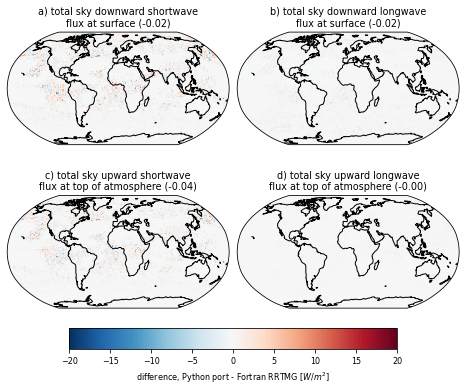

In [13]:
da = difference_time_mean[TOTAL_SKY_PLOT_VARS].to_array(dim='variable_names', name='total_sky_errors')
da = da.assign_coords({'variable_names': [name.item().replace('_', ' ').replace(' flux', '\nflux') for name in da.variable_names]})
means = da.weighted(GRID.area).mean(dim=['x', 'y', 'tile'])
fig, axes, h, _, fg = fv3viz.plot_cube(
    xr.merge(
        [
            da,
            GRID
        ]
    ),
    'total_sky_errors',
    col='variable_names',
    col_wrap=2,
    vmin=-20,
    vmax=20,
    colorbar=False,
    rasterized=True
)
[ax.set_title(f"{letter}) {mean.variable_names.item()} ({mean.item():0.2f})") for ax, mean, letter, in zip(axes.flatten(), means, ascii_lowercase)]
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.15, 0.15, 0.70, 0.05])
fig.colorbar(h[0], cax=cbar_ax, orientation='horizontal', label='difference, Python port - Fortran RRTMG [$W/{m^2}$]')
fig.set_size_inches([6.5, 6])
# fig.set_dpi(100)
# fig.savefig(f'{OUTDIR}/total_sky_validation_time_mean.png', bbox_inches='tight')
fig.savefig(f'{OUTDIR}/total_sky_validation_time_mean.pdf', bbox_inches='tight')